# Detecting edges from event data with Norse

![](https://github.com/norse/aestream/raw/main/example/usb_edgedetection.gif)

In this tutorial you will learn to

1. Read event-based files with [AEStream](https://github.com/norse/aestream)
2. Visualize them in Python
3. Use [Norse](https://github.com/norse/norse) to process the events

Event-based vision is an impressive technology that is unfortunately still a diamond in the rough.
Working with it works well in theory, but only recently have tools and libraries made it somewhat practical to work with.
AEStream simplifies the **reading, writing, and streaming** of event-based data and is one such tool: without it, it would take prohibitively long to work with event-based data representations.

One enticing application is spiking neural networks. This is where Norse comes in and in this tutorial you will learn to combine them both: read events from event-based binary files into a spiking neural network that does meaningful processing on the incoming events.

The complete code of the tutorial is available [at the AEStream repository](https://github.com/norse/aestream/blob/main/example/usb_edgedetection.py).

## 1. Reading event-based files with AEStream

![](https://camo.githubusercontent.com/311f3c90a229449ff8a1c1ca1040e7f3cd026c3a3f4e3317970f2c39fc10117f/68747470733a2f2f6a6567702e6769746875622e696f2f616573747265616d2d70617065722f323231325f616573747265616d2e737667)

AEStream is a tool that reads address-event (AE) representations and *streams* them to an output. While AEStream supports many inputs/outputs, we will focus on **reading a file and processing it with Norse**.
But note that AEStream has been used to stream events to neuromorphic hardware.
The only difference is a few lines of code.

Back to the problem at hand: let us first install and import AEStream.

**IF YOU ARE NOT ON GOOGLE COLAB, SKIP THIS CELL**

In [ ]:
!apt install g++-10 liblz4-dev && export CXX=g++-10

The above cell was solely for Google Colab. The below line installs aestream

In [ ]:
!pip install aestream

... So we now can import it into Python:

In [ ]:
import aestream

During this tutorial, we will process a sample of ~600MB, which is downloaded below:

In [ ]:
!wget -O sample.aedat4 https://cloud.jepedersen.dk/s/ze5Xjxe8wCHwkxD

With AEStream, we can now *open* the file:

In [ ]:
f = aestream.FileInput("sample.aedat4", (346, 280))

## 1.1 Operating onevents

We can split up the files in smaller bits of, say, 4 events and print them out, just like we would loop over them in Python:

In [ ]:
for e in f.parts(4):
    print(e)
    break

What you see here is a representation showing (`timestamp`, `x`, `y`, `polarity`) information.
This data format isn't terribly interesting to us.
In this notebook, we will be working with images and images consist of many events!

Let's arrange the events into a 2-d grid with `n` number of events, where `n = 1000`:

In [ ]:
frames = f.frames(1000)

Now we can ask, what is then the next frame?

In [ ]:
frame = next(frames)

# 2. Visualize events in Python

Once we have our frames, they are simple to visualize.
You might have noticed that the data representation is simple: `1`-values when there are events. `0`-values when not.
This can immediately be visualized in [matplotlib](https://matplotlib.org/).

If you are not familiar with matplotlib, try to read the code out loud: we are using matplotlib (`plt`) to show an image, pretending we can use our previous 2-d event frame as an image

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(frame)

PS: If you are annoyed that the frame is in portrait-format rather than landscape, try transposing it by writing `frame.T`.

Well. That frame is a little sparse. What happens if we increase the number of events to, say, 10000?

In [ ]:
frames = f.frames(10000)
frame = next(frames)
plt.imshow(frame.T)

It looks the same!
That is strange! We **should** be seeing something moving, since increasing the number of events effectively means using more input. Why do you think this is the case? Can you explore the data to figure out what's the matter?

---

What you see here is an annoying property of the event cameras. They are noisy and sometimes have faulty pixels, like this camera.
Check out the minimum and maximum values of the frame:

In [ ]:
frame.min(), frame.max()

We can fix this by clipping the values from 0 to 1:

In [ ]:
plt.imshow(frame.clip(0, 1).T)

Now this is starting to look like something! Let's draw the next frame.

In [ ]:
plt.imshow(next(frames).clip(0, 1).T)

# 3. Use Norse to process the events

In this part of the tutorial, we will create a small network in Norse that extracts horizontal and vertical edges from our event frames.

Our network consists of two layers:
1. A **refractory leaky integrate-and-fire layer** that filters out noisy pixels
2. A **2-d convolution** that applies a horizontal and vertical kernel to the incoming signal

We can write that up in Norse like so:

In [ ]:
# Import Norse and Torch
import norse, torch

# A refractory cell to inhibit pixels
refrac = norse.torch.LIFRefracCell()

# A convolutional edge-detection layer with kernel size 9 and two output channels
convolution = torch.nn.Conv2d(1, 2, 9, padding=12, bias=False, dilation=3)

# Put it all together
net = norse.torch.SequentialState(refrac, convolution)

Our kernels select for horizontal and vertical edges.
They will **excite** the stimulus along horizontal *or* vertical directions, suppressing everything else.
That is visually simple to represent:

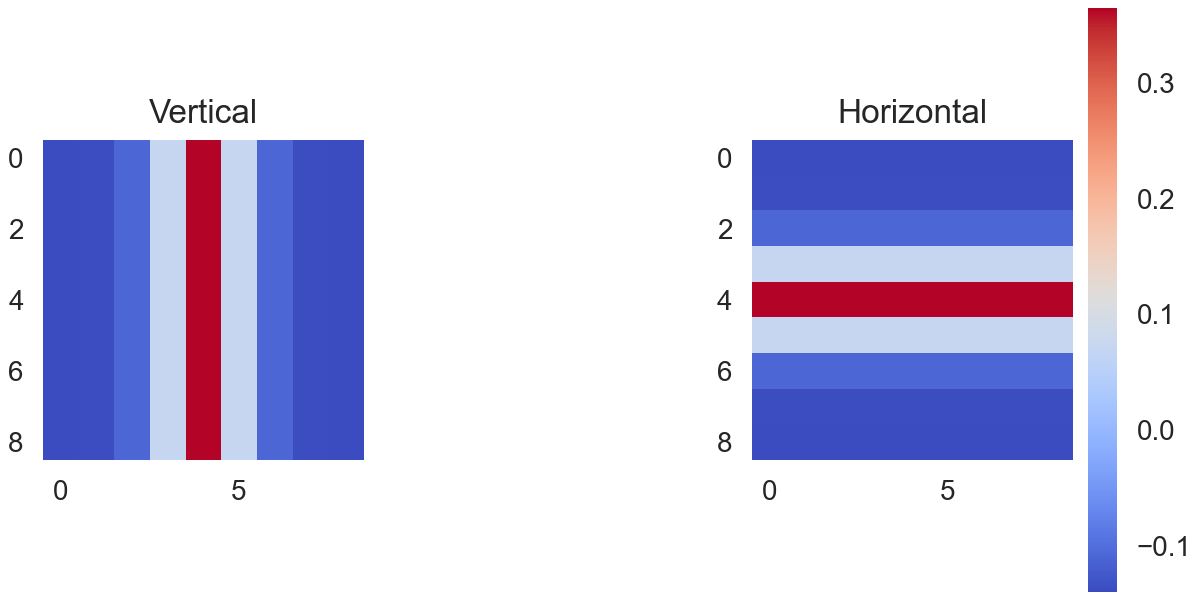

In code, this can be achieved by a number of ways.
Below, we are differentiating a sigmoid and "stretching" that into 2d.

If the code seem weird to you, try to unpack it and visualize the intermediate steps!

In [ ]:
# Create horizontal and vertical edge detectors
kernel_size = 9
gaussian = torch.sigmoid(torch.linspace(-10, 10, kernel_size + 1))
kernel = (gaussian.diff() - 0.14).repeat(kernel_size, 1)
kernels = torch.stack((kernel, kernel.T))
convolution = torch.nn.Conv2d(1, 2, kernel_size, padding=12, bias=False, dilation=3)
convolution.weight = torch.nn.Parameter(kernels.unsqueeze(1))

Finally, we can apply it to our data!
Recall that Norse requires state to keep track of the neuron dynamics.
Therefore, we initialize that to empty (None).

In [ ]:
state = None  # Start with empty state

Next, we can simply iterate over all the frames and apply our network.
Note that we are resizing the frame a bit to fit the format of PyTorch `(batch, channel, x, y)`

In [ ]:
processed = []
frame_input = aestream.FileInput("sample.aedat4", (346, 280)).frames(10000)
for frame in frame_input:
    resize = torch.tensor(frame.reshape(1, 1, 346, 280))
    with torch.no_grad():  # Exclude gradients
        out, state = net(resize, state)
        processed.append(out)

    # Only process 10 frames for now
    if len(processed) > 9:
        break

processed = torch.stack(processed)

In [ ]:
processed.shape

We now have a tensor of 10 timesteps, 1 batch, 2 output channels, and 346x280 pixels.
Let's visualize them!

In [ ]:
axes[1][1]

In [ ]:
f, axes = plt.subplots(2, 2)
axes[0, 0].imshow(processed[0, 0, 0].T)
axes[1, 0].imshow(processed[0, 0, 1].T)

axes[0, 1].imshow(processed[1, 0, 0].T)
axes[1, 1].imshow(processed[1, 0, 1].T)

What you see here is the very first step of a purely neural edge detector!
Try to put the image in series or [animate them using Matplotlib](https://matplotlib.org/stable/gallery/animation/dynamic_image.html).

# Conclusion

We worked with the event-based processing library AEStream, read event tensors out of the file, and processed them with a rudimentary Norse model.

AEStream is one part of a larger SNN toolbox ecosystem.
We used it in a step-wise frame-based manner, which is *actually not what it was desinged for*.
Rather, AEStream and Norse are toolsets for **streaming** sparse events.

If that interest you, check out [the website of AEStream](https://github.com/norse/norse), and the work we have done on [sending events over UDP](https://github.com/norse/aestream/blob/main/example/udp_client.py) to, for instance, neuromorphic hardware platforms [like SpiNNaker](http://apt.cs.manchester.ac.uk/projects/SpiNNaker/).

More notebooks are available at https://github.com/norse/notebooks.